In [1]:
## Example of subseasonal forecast of MJO with Markov chain 

import numpy as np
from matplotlib import pyplot as plt
import scipy.io as sio
import datetime
import warnings
from scipy.linalg import logm, expm
from scipy.interpolate import griddata

In [2]:
# load MJO data
rmm2=[float(l.split()[4]) for l in open('OMI_index.txt')]
rmm2=np.array(rmm2)
rmm2=-rmm2
rmm1=[float(l.split()[5]) for l in open('OMI_index.txt')]
rmm1=np.array(rmm1)

In [3]:
# develop Linear Inverse Model for forecast 
# there are two options to find the dynamical operator
# (1) using a single lag e.g., x(t+1) = G_1 x(t)+\epsilon or G_1 = [x(t+1)x(t)^T][x(t)x(t)^T]^(-1) 
# (2) using multiple lag e.g., G_ave  = exp([ln(G_1/1)+ln(G_2/2)+ln(G_3/3)...+ln(G_n/n)]/n)
# here we show you the second one with n = 20
# test 
total_length = np.size(rmm1)
n            = 20
G_record     = np.zeros((2,2,n))
for lag in range(1,n+1):
    x_0                 = np.squeeze([rmm1[:total_length-lag],rmm2[:total_length-lag]])
    x_tau               = np.squeeze([rmm1[lag:],rmm2[lag:]])
    reg                 = 1e1
    G                   = x_tau.dot(x_0.T).dot(np.linalg.inv(x_0.dot(x_0.T)))
    G_record[:,:,lag-1] = expm(logm(G)/lag)

In [5]:

# calculating the residual as forcing term 
x_0        = np.squeeze([rmm1[:-1],rmm2[:-1]])
x_tau      = np.squeeze([rmm1[1:],rmm2[1:]])
G_ave      = G_record.mean(axis=2) 
x_tau_hat  = G_ave.dot(x_0)
residual   = (x_tau_hat-x_tau)
xi = yi    = np.arange(-2,2.01,0.01)
xi,yi      = np.meshgrid(xi,yi)



# # calculate residual forcing (one can also use FDT)
residual_grid_rmm1 = np.zeros((401,401))
residual_grid_rmm2 = np.zeros((401,401))

for i in np.arange(0,401,1):
    for j in np.arange(0,401,1):
        # aggregrating the nearest data
        distance  = (rmm1[:-1]-(i-200)/100)**2+(rmm2[:-1]-(j-200)/100)**2  
        threshold = np.percentile(distance,3)
        posi      = np.squeeze(np.array(np.where(distance<threshold)))
        residual_grid_rmm1[j,i] = np.std(residual[0,posi])
        residual_grid_rmm2[j,i] = np.std(residual[1,posi])

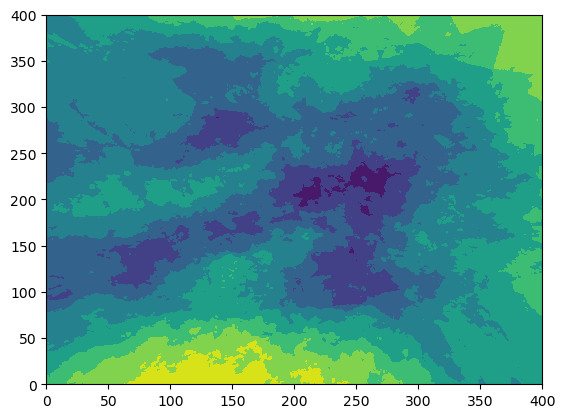

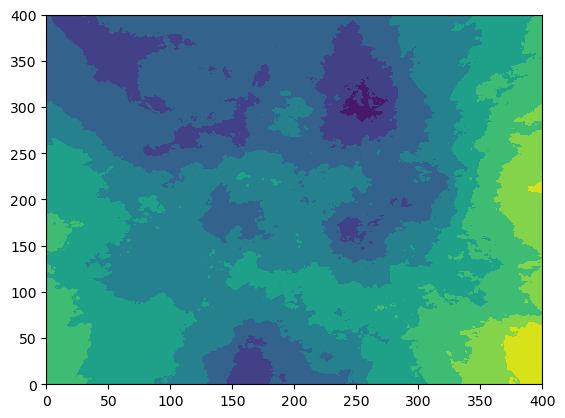

In [7]:
plt.figure()
plt.contourf(residual_grid_rmm1)
plt.figure()
plt.contourf(residual_grid_rmm2)